# Gráficos y mapas en Python con `geopandas` y `matplotlib` 

En este práctico, aprenderemos cómo cargar, manipular y visualizar datos espaciales. En algunos sentidos, los datos espaciales se han vuelto tan omnipresentes que hoy en día, por lo general, se incluyen simplemente como "una columna más" en una tabla. Sin embargo, el espacio es especial a veces y hay pocos aspectos en los que los datos geográficos difieren de las tablas numéricas estándar. En esta sesión, ampliaremos las habilidades desarrolladas en el anterior sobre datos no espaciales, y los combinaremos. En el proceso, descubriremos que, aunque con algunas particularidades, tratar con datos espaciales en Python se asemeja en gran medida a tratar con datos no espaciales. Por ejemplo, en esta práctica de laboratorio aprenderá a hacer mapas pulidos como este con solo unos pocos comandos:

![AYUDA](../img/plot.png)

La biblioteca principal empleada para todo esto es `geopandas`, que es una extensión geoespacial de la biblioteca de `pandas`, ya presentada en la clase anterior. `geopandas` admite exactamente la misma funcionalidad que `pandas` (de hecho, ya que está construida encima, por lo que la mayoría de los objetos subyacentes son de `pandas`), más una amplia gama de contrapartes espaciales que hacen manipulación general de datos espaciales tan fácil como tablas no-espaciales. Como las muñecas rusas, `geopandas` es una muñeca rusa que adentro contiene `pandas`.

![pandas y geopandas](https://images-na.ssl-images-amazon.com/images/I/71GnlJP8gVL._SX425_.jpg)

In [1]:
#importamos las librerías que veníamos trabajando 
import pandas as pd
import numpy as np

#y sumamos la que va a coronar la triada
import geopandas as gpd

## 1- GeoPandas, DataFrames como los de `Pandas`, pero Geo

In [2]:
#abrimos nuestro dataset espacial a partir de un archivo en el formato mas tradicional: ESRI shapefile 
estaciones = gpd.read_file('../carto/estaciones_de_subte.shp')
estaciones.head()

,ID,ESTACION,LINEA,geometry
0,1.0,CASEROS,H,POINT (105902.3513636972 99279.28209795424)
1,2.0,INCLAN,H,POINT (105715.5543212891 99986.54907226563)
2,3.0,HUMBERTO 1°,H,POINT (105591.8884887695 100683.6583251953)
3,4.0,VENEZUELA,H,POINT (105371.4735107422 101554.6354980469)
4,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (105252.2113037109 102254.3510742188)


In [3]:
#es muy siliar a pandas dataframe. vemos su tipo y vemos que es una especia de data frame
type(estaciones)

geopandas.geodataframe.GeoDataFrame

In [4]:
#tiene las mismas propiedades
estaciones.shape

(86, 4)

In [5]:
#info
estaciones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 4 columns):
ID          86 non-null float64
ESTACION    86 non-null object
LINEA       86 non-null object
geometry    86 non-null object
dtypes: float64(1), object(3)
memory usage: 2.8+ KB


In [6]:
#se indexa por fila
estaciones.index

RangeIndex(start=0, stop=86, step=1)

In [7]:
#tambien por columnas
estaciones.columns

Index(['ID', 'ESTACION', 'LINEA', 'geometry'], dtype='object')

En las columnas vemos ya el elemento que hace a este *data frame* algo diferente a los de `pandas`: el campo **geometry** 

In [8]:
estaciones.geometry.head()

0    POINT (105902.3513636972 99279.28209795424)
1    POINT (105715.5543212891 99986.54907226563)
2    POINT (105591.8884887695 100683.6583251953)
3    POINT (105371.4735107422 101554.6354980469)
4    POINT (105252.2113037109 102254.3510742188)
Name: geometry, dtype: object

In [9]:
#Pero a pesar de ser el elemento que diferencia un DataFrame de un GeoDataFrame, guarda similitud con un objeto conocido de Pandas
#, geometry es una geoseries, similar a una series de pandas. 
type(estaciones.geometry)

geopandas.geoseries.GeoSeries

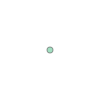

In [10]:
#es una geoSerie de que? que elementos la componen? que muñeca rusa más pequeña hay dentro?
estaciones.geometry.iloc[0]

In [11]:
print(estaciones.geometry.iloc[0])

POINT (105902.3513636972 99279.28209795424)


In [12]:
#es un objeto Shapely. La librería que funciona por debajo de GeoPandas 
type(estaciones.geometry.iloc[0])

shapely.geometry.point.Point

### Shapely

Las GeoSeries de Geopandas son una Series que adentro contiene objetos que no son ni `string`, ni numeros. Son objetos particulares, como los `datetime`, pero cuyas propiedades específicas son geográficas. En lugar de extraer horas o días de la semana, vamos a poder obtener propiedades geográficas como distancias de un punto a otro. O coordenadas...

## 2- Coordenadas

En lo fundamental los GeoDatos, no dejan de ser los datos que trabajamos cotidianamente, pero con alguna referencia a su ubicación en el espacio, que creemos relevante por lo cual la introducimos en el análisis. Esa referencia al espacio debe corporizarse en algun tipo de objeto geografico, de los cuales utilizaremos 3 básicos:
* Punto
* Línea
* Polígono

En nuestro ejemplo, la estaciones de subte son puntos. El elemento geográfico más sencillo. En la geometría euclidiana, o de dos dimensiones, un punto se define por dos valores:

In [13]:
#un punto son dos coordenadas en el espacio
estaciones.geometry.iloc[0].x

105902.35136369725

In [14]:
estaciones.geometry.iloc[0].y

99279.28209795424

Tiene x y y, coordenadas en el eje cartesiano. Ojo que lo que siempre en matematica se llama x y y en ese orden, en geografia siempre se llamo latlong, pero x es long y y es lat. El orden cambia!
![latlong](../img/xy_latlong.jfif)

Pero es algo diferente a lo que siempre conocimos como latlong. En general estamos acostumbrados en mapas de Buenos Aires a ver valores como -34 y -58. La diferencia se explica por la llamada **proyeccion de coordenadas** que da cuenta de la transformación de un objeto en 3 dimensiones (como el planeta Tierra) en un plano de 2 dimensiones (el mapa). Esta proyección también regula las unidades de medidas de los ejes donde proyectamos. Puede estar en grados o en metros.

Podemos acceder a la **proyeccion de coordenadas** de un GeoDataFrame de manera sencilla. 

In [15]:
#con el metodo o funcion crs vemos la proyeccion de nuestro objeto
estaciones.crs

{'ellps': 'intl',
 'k': 0.999998,
 'lat_0': -34.6297166,
 'lon_0': -58.4627,
 'no_defs': True,
 'proj': 'tmerc',
 'units': 'm',
 'x_0': 100000,
 'y_0': 100000}

La proyeccion de este GeoDataFrame está en un formato de coordenadas especifica [SR-ORG:7124: Gauss-Kruger Bs.As.](http://spatialreference.org/ref/sr-org/7124/). Pueden leer más en la [documentación](https://recursos-data.buenosaires.gob.ar/ckan2/proyecciones-gkba.pdf) de GCBA sobre el tema.

Queremos reproyectarla en [EPSG 4326](https://epsg.io/4326) cuya unidad de medida es grados. Afortunadamente GeoPandas implementa esto de una manera muy sencilla. La documentación de [GeoPandas](http://geopandas.org/projections.html) tiene más detalles. 



In [16]:
#cambiamos al formato tradicional de latlong
estaciones = estaciones.to_crs(epsg = 4326)
estaciones.head()

,ID,ESTACION,LINEA,geometry
0,1.0,CASEROS,H,POINT (-58.39833005827354 -34.63619629114226)
1,2.0,INCLAN,H,POINT (-58.40037199947714 -34.62982192437689)
2,3.0,HUMBERTO 1°,H,POINT (-58.40172516912597 -34.62353873781329)
3,4.0,VENEZUELA,H,POINT (-58.40413412280196 -34.61568876109078)
4,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40543878453062 -34.60938200117359)


In [17]:
print(estaciones.geometry.iloc[0])

POINT (-58.39833005827354 -34.63619629114226)


Ya podemos ver que las coordenadas de nuestros puntos se asemejan a los valores que intuitivamente conocíamos para Buenos Aires
![latlong2](../img/latlong.png)

A partir de este momento, intentaremos visualizar todos los procesos que realizamos en un mapa. Para esto necesitamos la librería de Python que administra los gráficos: `matplotlib` 

In [18]:
#y sumamos la libreria que nos permite visualizar co alias plt
import matplotlib.pyplot as plt
#esta linea nos permite visualizar los plots y mapas dentro de nuestros notebooks
%matplotlib inline

En este curso haremos un uso muy utilitario de matplotlib. Es decir, presenaremos sus elementos fundamentales sin profundizar demasiado. Es una herramienta muy versatil y pontente. También mencionaremos las otras mas populares como `seaborn` y `plotly`. 

`Matplotlib` se construye fundamentalmente a partir de una **figura** que puede tener dentro uno o mas **ejes** (o *axis*)

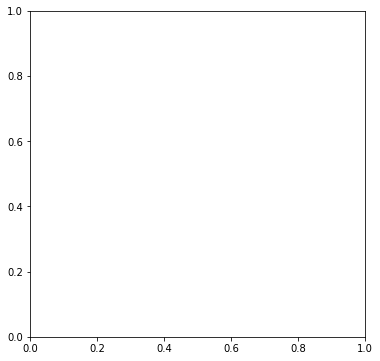

In [19]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

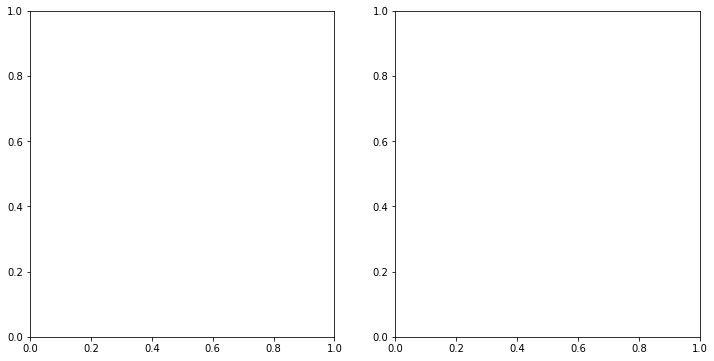

In [20]:
#agrando el tamaño de la figura
fig = plt.figure(figsize=(12,6))
#en 1 columna agrego 2 pares de ejes 
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


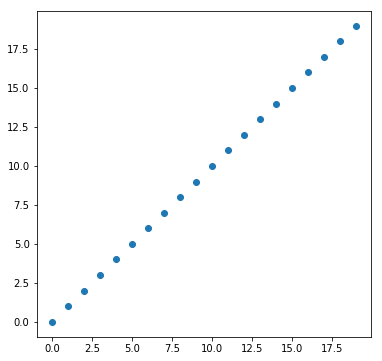

In [21]:
#puedo agregar contenido a los graficos al graficar algunos datos
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
#un listado de 0 a 19
x = range(20)
y = range(20)
#plotear un scatter plot 
ax.scatter(x,y)

In [22]:
#utilizando el metodo map, puedo extraer para cada punto sus coordenadas en x
estaciones['x'] = estaciones.geometry.map(lambda coord: coord.x)
estaciones.head()

,ID,ESTACION,LINEA,geometry,x
0,1.0,CASEROS,H,POINT (-58.39833005827354 -34.63619629114226),-58.398330
1,2.0,INCLAN,H,POINT (-58.40037199947714 -34.62982192437689),-58.400372
2,3.0,HUMBERTO 1°,H,POINT (-58.40172516912597 -34.62353873781329),-58.401725
3,4.0,VENEZUELA,H,POINT (-58.40413412280196 -34.61568876109078),-58.404134
4,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40543878453062 -34.60938200117359),-58.405439


Afortunadamente, los desarolladors de GeoPandas entendieron que esto es una tarea cotidiana y pusieron como metodo propio de las geoSeries extraer las coordenadas

In [23]:
estaciones['y'] = estaciones.geometry.y
estaciones.head()

,ID,ESTACION,LINEA,geometry,x,y
0,1.0,CASEROS,H,POINT (-58.39833005827354 -34.63619629114226),-58.398330,-34.636196
1,2.0,INCLAN,H,POINT (-58.40037199947714 -34.62982192437689),-58.400372,-34.629822
2,3.0,HUMBERTO 1°,H,POINT (-58.40172516912597 -34.62353873781329),-58.401725,-34.623539
3,4.0,VENEZUELA,H,POINT (-58.40413412280196 -34.61568876109078),-58.404134,-34.615689
4,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40543878453062 -34.60938200117359),-58.405439,-34.609382


Utilizando estas coordenadas podemos visualizar la ubicacion de nuestras estaciones en un mapa, visualizandolas sobre el eje de coordenadas utilizando su posicion en x y en y

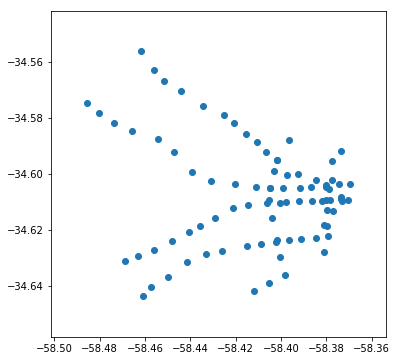

In [24]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(estaciones.x,estaciones.y)

Afortunadamente los desarrolladores de GeoPandas tambien pensaron que esta tarea debía poder resolverse de manera más sencilla:

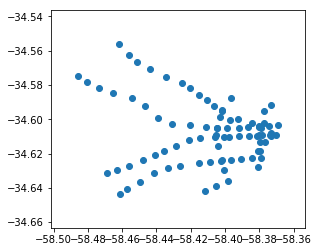

In [25]:
#al igual que los DataFrames de Pandas, los GeoDataFrames tienen un método (o función) plot que visualiza los objetos espaciales. 
estaciones.drop(['x','y'],axis=1).plot()

## 3 - Procesos de seleccion en `geopandas`

In [26]:
estaciones.head()

,ID,ESTACION,LINEA,geometry,x,y
0,1.0,CASEROS,H,POINT (-58.39833005827354 -34.63619629114226),-58.398330,-34.636196
1,2.0,INCLAN,H,POINT (-58.40037199947714 -34.62982192437689),-58.400372,-34.629822
2,3.0,HUMBERTO 1°,H,POINT (-58.40172516912597 -34.62353873781329),-58.401725,-34.623539
3,4.0,VENEZUELA,H,POINT (-58.40413412280196 -34.61568876109078),-58.404134,-34.615689
4,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40543878453062 -34.60938200117359),-58.405439,-34.609382


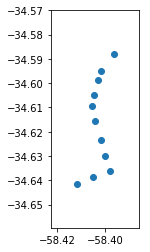

In [27]:
#podemos seleccionar
estaciones.loc[estaciones.LINEA=='H',:].plot()

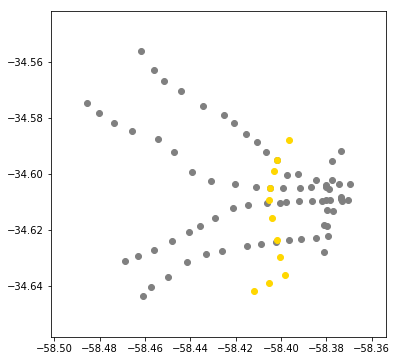

In [28]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
estaciones.loc[estaciones.LINEA!='H',:].plot(ax=ax,color='grey')
estaciones.loc[estaciones.LINEA=='H',:].plot(ax=ax,color='gold')

(-58.501464246260447,
 -58.353654423017261,
 -34.658259560906295,
 -34.541588867405785)

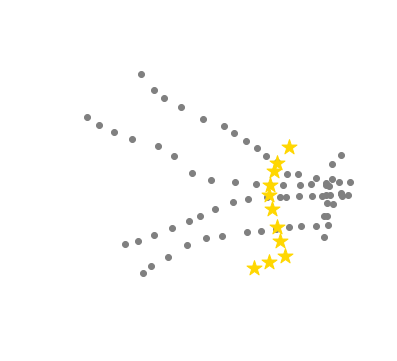

In [29]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
estaciones.loc[estaciones.LINEA!='H',:].plot(ax=ax,color='grey')
estaciones.loc[estaciones.LINEA=='H',:].plot(ax=ax,color='gold',marker='*', markersize=250)

#eliminamos los ejes
ax.set_axis_off()
# Forzamos un mismo rango de valors a los ejes para una vision mas "cuadrada" del mapa
plt.axis('equal')

## 4- Distancias

Pero lo mejor es poder realizar procesos espaciales. Por ejemplo, podemos ver utilizar una harramienta de análisis básica y fundamental del análisis espacial para los objetos de tipo punto: la distancia euclidiana.

$$\sqrt[2]{(x_d - x_o)^{2}+(y_d - y_o)^{2}}$$

In [30]:
import math
constitucion = estaciones.loc[estaciones.ESTACION == 'CONSTITUCION',:]
retiro = estaciones.loc[estaciones.ESTACION == 'RETIRO',:]
math.sqrt((retiro.x.iloc[0] - constitucion.x.iloc[0])**2 + (retiro.y.iloc[0] - constitucion.y.iloc[0])**2)

0.037172056858999235

Afortunadamente esto no es algo que tenemos que hacer cada vez. `Geopandas` y `Shapely` lo resuelven por nosotros. De hecho, podríamos ir desde al bajo nivel (las muñecas rusas pequeñas, calculando distancias con cada punto) como hicimos con la extracción de las coordenadas x y y, o podemos directamente ver en alto nivel (la muñeca más grande) cómo lo implementa GeoPandas. Veamos primero en alto nivel y luego procedemos por el lento y sinuoso camino del bajo nivel

In [31]:
#convertirmos todo nuestro dataset a una proyeccion con unidades en metros. Luego veremos en mas detalle 
estaciones = estaciones.to_crs(epsg=3857)

In [32]:
#necesitamos calcular la distancia de nuestras estaciones con respecto a algo, no existe la distancia a la nada
from shapely.geometry import Point #mas adelante veremos esta linea
obelisco = Point(-6499048.3,-4110245.4)

![obelisco](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/ObeliscoBA2017.jpg/245px-ObeliscoBA2017.jpg)

In [33]:
#una forma es mapear
estaciones['distancia'] = estaciones.geometry.map(lambda x: x.distance(obelisco))
estaciones.head()

,ID,ESTACION,LINEA,geometry,x,y,distancia
0,1.0,CASEROS,H,POINT (-6500872.365264534 -4114550.922561814),-58.398330,-34.636196,4675.974617
1,2.0,INCLAN,H,POINT (-6501099.673119548 -4113688.521703297),-58.400372,-34.629822,4007.894552
2,3.0,HUMBERTO 1°,H,POINT (-6501250.307275812 -4112838.521641664),-58.401725,-34.623539,3401.928261
3,4.0,VENEZUELA,H,POINT (-6501518.470772369 -4111776.653996726),-58.404134,-34.615689,2906.283270
4,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-6501663.705051661 -4110923.61029132),-58.405439,-34.609382,2701.909100


In [34]:
#pero afortunadamente GeoPandas puede aplicar este metodo a toda la Serie
estaciones['distancia'] = estaciones.geometry.distance(obelisco)
estaciones.head()

,ID,ESTACION,LINEA,geometry,x,y,distancia
0,1.0,CASEROS,H,POINT (-6500872.365264534 -4114550.922561814),-58.398330,-34.636196,4675.974617
1,2.0,INCLAN,H,POINT (-6501099.673119548 -4113688.521703297),-58.400372,-34.629822,4007.894552
2,3.0,HUMBERTO 1°,H,POINT (-6501250.307275812 -4112838.521641664),-58.401725,-34.623539,3401.928261
3,4.0,VENEZUELA,H,POINT (-6501518.470772369 -4111776.653996726),-58.404134,-34.615689,2906.283270
4,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-6501663.705051661 -4110923.61029132),-58.405439,-34.609382,2701.909100


Text(0.5,1,'Estaciones de subte y distancia al Obelisco')

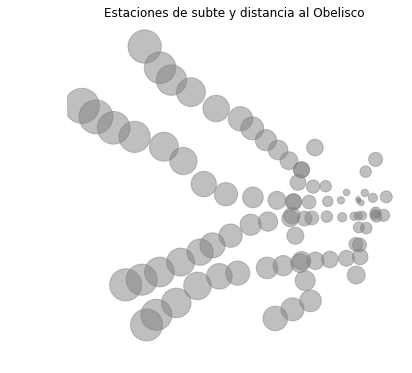

In [35]:
#veamoslo en un mapa
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
estaciones.plot(ax=ax,color='grey',markersize=(estaciones.distancia/10),alpha=0.5) 
ax.set_axis_off()
plt.axis('equal')
ax.set_title('Estaciones de subte y distancia al Obelisco')

### Digresión por el camino lento y aburrido del bajo nivel

In [36]:
#revertimos el proceso para volver a nuestra base a latlong
estaciones = estaciones.to_crs(epsg=4326)

In [37]:
#primero seleccionemos nuestras dos estaciones
constitucion = estaciones.loc[estaciones.ESTACION == 'CONSTITUCION','geometry'].iloc[0]
retiro = estaciones.loc[estaciones.ESTACION == 'RETIRO','geometry'].iloc[0]

In [38]:
constitucion.distance(retiro)

0.037172056859006194

Veamos algunas cosas que acaban de suceder. En primer lugar que significa 0.03? En que unidades de medidas se encuentra? Esto depende de la proyeccion de coordenadas que utilizamos

In [39]:
estaciones.crs

{'init': 'epsg:4326', 'no_defs': True}

La proyeccion de este GeoDataFrame está en [EPSG 4326](https://epsg.io/4326) cuya unidad de medida es grados. Hay muchas proyecciones que utilizan metros. Como la proyeción óptima depende de la ubicación en el planeta donde hagamos nuestro análisis, podemos utilizar una sencilla de alcance global como la [EPSG 3857](https://epsg.io/3857).

Pero tenemos que saber qué tipo de objetos nos dejan cambiar las proyecciones. Porque no es lo mismo un **GeoDataFrame**, una **GeoSeries** o un objeto **Shapely**.

In [40]:
#repitamos el mismo proceso convirtiendo a metros
constitucion = estaciones.loc[estaciones.ESTACION == 'CONSTITUCION','geometry'].to_crs(epsg=3857).iloc[0]
retiro = estaciones.loc[estaciones.ESTACION == 'RETIRO','geometry'].to_crs(epsg=3857).iloc[0]
constitucion.distance(retiro)

4995.298837542108

Reconstruyamos paso a paso lo que hicimos previamente, y veamos con que tipo de objetos tratamos. Primero buscamos nuestra estación con `.loc` tal cual lo veníamos haciendo

In [41]:
#a priori observamos que hay un numero al lado, lo que indica que tiene un indice y por ende sea probablementa Serie
constitucion = estaciones.loc[estaciones.ESTACION == 'CONSTITUCION','geometry']
constitucion

18    POINT (-58.38083760902074 -34.62806566363901)
Name: geometry, dtype: object

In [42]:
type(constitucion)

geopandas.geoseries.GeoSeries

El problema con calcular distancias, es que siempre una distancia es de un punto a otro. Si utilizamos una serie, la misma puede tener 2, 3 o *n* elementos. Por eso tenemos que partir siempre de un punto y no de una serie. Eso hace el `iloc[0]`, toma el primer (y único) elemento de la serie. 

In [43]:
constitucion = estaciones.loc[estaciones.ESTACION == 'CONSTITUCION','geometry'].iloc[0]
type(constitucion)

shapely.geometry.point.Point

Ahora podemos ver que el tipo es un `Shapely` **Point**. Hemos llegado a la muñeca rusa más pequeña (al menos la más pequeña que veremos en este taller, donde no llegamos al transistor, el bit y los 1 y 0).

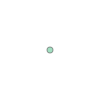

In [44]:
constitucion

De hecho, veamos que la función `disatnce()` pertenece al objeto **Point**, no a Python básico, Pandas o Geopandas. Es propia de **Point**

In [45]:
#importamos el objeto Point desde la libreria shapely
from shapely.geometry import Point
help(Point.distance)

Help on function distance in module shapely.geometry.base:

distance(self, other)
    Unitless distance to other geometry (float)



Pero ademas noten que al elegir solo la columna **geometry**, no usamos []. Si lo hubiesemos hecho, hubiesemos obtenido una Serie y deberiamos haberlo repetido dos veces 

In [46]:
#esto devuelve un data frame
estaciones.iloc[[0],[0]]

,ID
0,1.0


In [47]:
#esto una Series
estaciones.iloc[0,[0]]

ID    1
Name: 0, dtype: object

In [48]:
#esto un numero, el contenido dentro de la celda
estaciones.iloc[0,0]

1.0

In [49]:
#al usar un filtro que devuelve una lista de True y False, devuelve una lista
constitucion = estaciones.loc[estaciones.ESTACION == 'CONSTITUCION','geometry']
type(constitucion)


geopandas.geoseries.GeoSeries

In [50]:
#noten que al filtrar las filas, usamos una serie
type(estaciones.ESTACION == 'CONSTITUCION')

pandas.core.series.Series

In [51]:
#con iloc[0] extraemos el elemento dentro de la Series
constitucion = estaciones.loc[estaciones.ESTACION == 'CONSTITUCION','geometry'].iloc[0]

type(constitucion)


shapely.geometry.point.Point

Ahora si ya comprendemos que tenemos que calcular la distancia entre dos puntos, y para eso debemos urgar dentro de la muñeca de `GeoPandas` **DataFrame**, dentro de la **GeoSeries** geometry hasta el **Punto** de `Shapely`.

In [52]:
constitucion = estaciones.loc[estaciones.ESTACION == 'CONSTITUCION','geometry'].to_crs(epsg=3857).iloc[0]
retiro = estaciones.loc[estaciones.ESTACION == 'RETIRO','geometry'].to_crs(epsg=3857).iloc[0]
constitucion.distance(retiro)

4995.298837542108

Sin embargo, recordemos que el concepto de proyección de coordenadas es propio de `GeoPandas`, no de `Shapely`. Podemos convertir todo un **GeoDataFrame** o una **Series**, pero no un **Punto**

In [53]:
estaciones.to_crs(epsg=3857).head()

,ID,ESTACION,LINEA,geometry,x,y,distancia
0,1.0,CASEROS,H,POINT (-6500872.365264534 -4114550.922561814),-58.398330,-34.636196,4675.974617
1,2.0,INCLAN,H,POINT (-6501099.673119548 -4113688.521703297),-58.400372,-34.629822,4007.894552
2,3.0,HUMBERTO 1°,H,POINT (-6501250.307275812 -4112838.521641664),-58.401725,-34.623539,3401.928261
3,4.0,VENEZUELA,H,POINT (-6501518.470772369 -4111776.653996726),-58.404134,-34.615689,2906.283270
4,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-6501663.705051661 -4110923.61029132),-58.405439,-34.609382,2701.909100


In [54]:
estaciones.geometry.to_crs(epsg=3857).head()

0    POINT (-6500872.365264534 -4114550.922561814)
1    POINT (-6501099.673119548 -4113688.521703297)
2    POINT (-6501250.307275812 -4112838.521641664)
3    POINT (-6501518.470772369 -4111776.653996726)
4     POINT (-6501663.705051661 -4110923.61029132)
Name: geometry, dtype: object

In [55]:
estaciones.geometry.iloc[0].to_crs(epsg=3857)

AttributeError: 'Point' object has no attribute 'to_crs'

Por eso siempre que utilicemos procesos espaciales, debemos comprender conceptualmente si ese método se aplica a un punto, a un conjunto de puntos, etc. Una distancia es siempre de punto a punto. Pero podríamos querer obtener una distancia de todas las estaciones a un punto, por ejemplo el Obelisco.

### Fin de la digresión por el camino lento y aburrido del bajo nivel

## 5- Lineas

Ahora podemos tratar con el siguiente objeto geografico en terminos de complejidad. La linea 

In [56]:
lineas = gpd.read_file('../carto/lineas_de_subte.shp')
lineas

,id,Linea,geometry
0,1,A,LINESTRING (-58.46975741265597 -34.63057613832...
1,2,B,LINESTRING (-58.48656121515003 -34.57422942804...
2,3,C,LINESTRING (-58.38141172337224 -34.62732958019...
3,4,D,LINESTRING (-58.46196778708097 -34.55593795056...
4,5,E,LINESTRING (-58.46196701863403 -34.64345502880...
5,6,H,LINESTRING (-58.41256333829378 -34.64110314761...


Como comentamos en otras clases, tener indices reales, que den cuenta de los datos puede ser muy util. Hagamos eso


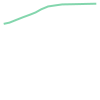

In [57]:
#si quiero seleccionar la A seria algo más complejo como
lineas.loc[lineas.Linea == 'A','geometry'].iloc[0]

In [58]:
#le cambiamos los indices a la linea
lineas.index = lineas.Linea
#eliminamos variables que no nos sirven
lineas = lineas.drop(['id','Linea'],axis=1)
#la convertimos en metros
lineas = lineas.to_crs(epsg=3857)
lineas

,geometry
Linea,
A,LINESTRING (-6508823.621983094 -4113790.557363...
B,LINESTRING (-6510694.212720125 -4106170.107942...
C,LINESTRING (-6498989.02483825 -4113351.3454824...
D,LINESTRING (-6507956.484830616 -4103697.440260...
E,LINESTRING (-6507956.399287493 -4115533.052444...
H,LINESTRING (-6502456.806748704 -4115214.826158...


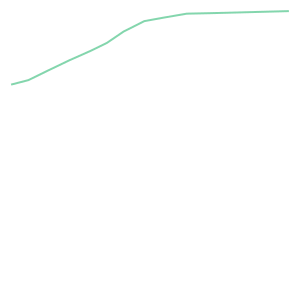

In [59]:
#ahora veamos que es más sencillo de trabajar, sin iloc ni listas de Trues y False
lineas.loc['A','geometry']

In [60]:
#vemos que el tipo para linea de shapely es LineString
H = lineas.loc['H','geometry']
type(H)

shapely.geometry.linestring.LineString

In [61]:
#tiene sus propios metodos especificos a la linea
H.length

8468.993329266123

In [62]:
#y tiene varios pares de coordenadas
len(H.coords)

4

In [63]:
list(H.coords)

[(-6502456.806748704, -4115214.8261582623),
 (-6500959.194922459, -4114441.7362974873),
 (-6501710.225146142, -4110819.2934147594),
 (-6500746.616416474, -4107889.559358372)]

In [64]:
#una linea no es más que una secuencia de puntos
H.coords[0],H.coords[1]

((-6502456.806748704, -4115214.8261582623),
 (-6500959.194922459, -4114441.7362974873))

In [65]:
#si queremos convertir una linea a un punto podemos usar uno de sus vertices o el centroide
print(H.centroid)

POINT (-6501370.290049281 -4111874.837956012)


In [66]:
#convertimos todo a 3857
estaciones = estaciones.to_crs(epsg=3857)

In [67]:
estaciones_H = estaciones.loc[estaciones.LINEA == 'H',['ESTACION','geometry']]
estaciones_H

,ESTACION,geometry
0,CASEROS,POINT (-6500872.365264534 -4114550.922561814)
1,INCLAN,POINT (-6501099.673119548 -4113688.521703297)
2,HUMBERTO 1°,POINT (-6501250.307275812 -4112838.521641664)
3,VENEZUELA,POINT (-6501518.470772369 -4111776.653996726)
4,ONCE - 30 DE DICIEMBRE,POINT (-6501663.705051661 -4110923.61029132)
76,CORRIENTES,POINT (-6501598.471925394 -4110322.432566255)
77,PARQUE PATRICIOS,POINT (-6501636.792732302 -4114910.248023052)
78,HOSPITALES,POINT (-6502370.395089394 -4115297.612428813)
83,CÓRDOBA,POINT (-6501406.0311146 -4109506.256469619)
84,LAS HERAS,POINT (-6500681.830667321 -4108019.654066862)


## 6 - LRS Lineal Referencing System

Este proceso es uno de los más utilizados en análisis espacial. Fundamentalmente proyecta un punto sobre una línea siguiendo la distancia más corta, y nos indica a que distancia lineal sobre esa línea se encuentra. 

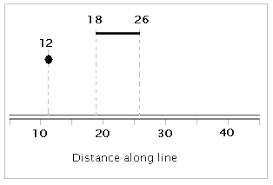

In [68]:
#importamos el objeto LineString
from shapely.geometry import LineString

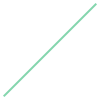

In [69]:
#creamos una linea apartir de dos puntos
l = LineString([Point(0,0),Point(1,1)])
l

In [70]:
#proyectamos el punto con coordenadas 0.5,0.5
l.project(Point(0.5,0.5))

0.7071067811865476

In [71]:
l.project?

In [72]:
#interpolamos esa distancia para ver las coordenadas del punto
print(l.interpolate(0.707))

POINT (0.499924494298889 0.499924494298889)


## Las estaciones de subte están más cerca en el centro?

El análisis que queremos realizar es veríficar si las estaciones de subte se encuentran más separadas entre sí en la periféria de la red que en el centro. También queremos poder ordenar nuestras estaciones en un gráfico de barras de acuerdo al orden que siguen en la línea. Para eso nos sirve el LRS

Necesitamos calcular la distancia de cada estácion con la siguiente. Por eso necesitamos sabe el orden de esas estaciones.

In [73]:
#utilizamos map 
estaciones_H['orden'] = estaciones_H.geometry.map(H.project)
#ordenamos por el orden y hacemos un reset del index
estaciones_H = estaciones_H.sort_values(by='orden')
estaciones_H = estaciones_H.reset_index(drop=True)
estaciones_H

,ESTACION,geometry,orden
0,HOSPITALES,POINT (-6502370.395089394 -4115297.612428813),38.810154
1,PARQUE PATRICIOS,POINT (-6501636.792732302 -4114910.248023052),868.366830
2,CASEROS,POINT (-6500872.365264534 -4114550.922561814),1685.381000
3,INCLAN,POINT (-6501099.673119548 -4113688.521703297),2451.429636
4,HUMBERTO 1°,POINT (-6501250.307275812 -4112838.521641664),3314.310107
5,VENEZUELA,POINT (-6501518.470772369 -4111776.653996726),4408.505986
6,ONCE - 30 DE DICIEMBRE,POINT (-6501663.705051661 -4110923.61029132),5273.270494
7,CORRIENTES,POINT (-6501598.471925394 -4110322.432566255),5891.762080
8,CÓRDOBA,POINT (-6501406.0311146 -4109506.256469619),6727.204518
9,SANTA FE - CARLOS JAUREGUI,POINT (-6501256.279262598 -4108974.83962486),7278.805759


##### VERSION LIGERAMENTE MÁS COMPLEJA

`project` permite que nos de la distancia sobre la línea en unidades de medida o en procentaje: el punto está a la mitad de la linea (50%) o al final (100%). Para eso toma un parámetro adicional como `normalized`. 

Combinar `lambda` con `map` nos permite combinar un elemento variable sobre el cual vamos iterando nuestra función, con parámetros fijos.


In [74]:
#esto nos permite utilizar "estacion" como un elemento variable y el parametro fijo normalized
estaciones_H['orden'] = estaciones_H.geometry.map(lambda estacion: H.project(estacion,normalized = True))
estaciones_H = estaciones_H.sort_values(by='orden')
estaciones_H = estaciones_H.reset_index(drop=True)
estaciones_H

,ESTACION,geometry,orden
0,HOSPITALES,POINT (-6502370.395089394 -4115297.612428813),0.004583
1,PARQUE PATRICIOS,POINT (-6501636.792732302 -4114910.248023052),0.102535
2,CASEROS,POINT (-6500872.365264534 -4114550.922561814),0.199006
3,INCLAN,POINT (-6501099.673119548 -4113688.521703297),0.289459
4,HUMBERTO 1°,POINT (-6501250.307275812 -4112838.521641664),0.391346
5,VENEZUELA,POINT (-6501518.470772369 -4111776.653996726),0.520547
6,ONCE - 30 DE DICIEMBRE,POINT (-6501663.705051661 -4110923.61029132),0.622656
7,CORRIENTES,POINT (-6501598.471925394 -4110322.432566255),0.695686
8,CÓRDOBA,POINT (-6501406.0311146 -4109506.256469619),0.794333
9,SANTA FE - CARLOS JAUREGUI,POINT (-6501256.279262598 -4108974.83962486),0.859465


In [75]:
#Ahora que estan ordenadas, cuál es la siguiente estacion?
estaciones_H.ESTACION.shift(-1)

0               PARQUE PATRICIOS
1                        CASEROS
2                         INCLAN
3                    HUMBERTO 1°
4                      VENEZUELA
5         ONCE - 30 DE DICIEMBRE
6                     CORRIENTES
7                        CÓRDOBA
8     SANTA FE - CARLOS JAUREGUI
9                      LAS HERAS
10                           NaN
Name: ESTACION, dtype: object

In [76]:
#no siempre tenemos que guardar todo en el data frame, en especial variables que van a ser insumo
estacion_siguiente = estaciones_H.geometry.shift(-1)

In [77]:
#calculamos la distancia de cada estacion con respecto a su siguiente
#sabemos que tenemos que repetir esto por cada estacion menos 1 (la ultima tiene distancia a la nada)
list(range(len(estaciones_H)-1))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [78]:
#podemos ver las estaciones recorriendo este rango
for i in range(len(estaciones_H)-1):
    print(estaciones_H.ESTACION.iloc[i])
    #noten como Las Heras no aparece
    

HOSPITALES
PARQUE PATRICIOS
CASEROS
INCLAN
HUMBERTO 1°
VENEZUELA
ONCE - 30 DE DICIEMBRE
CORRIENTES
CÓRDOBA
SANTA FE - CARLOS JAUREGUI


In [79]:
#hacemos esto con un list compehension
distancias = [estaciones_H.geometry.iloc[i].distance(estacion_siguiente.iloc[i]) for i in range(len(estaciones_H)-1)]

In [80]:
#tomamos la decisión de darle una distancia 0 a la ultima
estaciones_H['distancias_siguiente'] = distancias + [0]

In [81]:
estaciones_H

,ESTACION,geometry,orden,distancias_siguiente
0,HOSPITALES,POINT (-6502370.395089394 -4115297.612428813),0.004583,829.592431
1,PARQUE PATRICIOS,POINT (-6501636.792732302 -4114910.248023052),0.102535,844.668065
2,CASEROS,POINT (-6500872.365264534 -4114550.922561814),0.199006,891.854305
3,INCLAN,POINT (-6501099.673119548 -4113688.521703297),0.289459,863.244319
4,HUMBERTO 1°,POINT (-6501250.307275812 -4112838.521641664),0.391346,1095.205258
5,VENEZUELA,POINT (-6501518.470772369 -4111776.653996726),0.520547,865.318762
6,ONCE - 30 DE DICIEMBRE,POINT (-6501663.705051661 -4110923.61029132),0.622656,604.706555
7,CORRIENTES,POINT (-6501598.471925394 -4110322.432566255),0.695686,838.556430
8,CÓRDOBA,POINT (-6501406.0311146 -4109506.256469619),0.794333,552.113648
9,SANTA FE - CARLOS JAUREGUI,POINT (-6501256.279262598 -4108974.83962486),0.859465,1114.616813


In [82]:
#siguiendo el mismo procedimiento, podemos construir una linea a partir de cada estacion con la siguiente
lineas_nuevas = [LineString([estaciones_H.geometry.loc[i],estacion_siguiente.loc[i]]) for i in estaciones_H.index[:-1]]
lineas_nuevas

In [83]:
#creamos un data frame con lineas y la distancia
nuevaH = pd.DataFrame({'lineas':lineas_nuevas,
             'distancia':distancias})
type(nuevaH)

pandas.core.frame.DataFrame

In [84]:
nuevaH.head()

,lineas,distancia
0,LINESTRING (-6502370.395089394 -4115297.612428...,829.592431
1,LINESTRING (-6501636.792732302 -4114910.248023...,844.668065
2,LINESTRING (-6500872.365264534 -4114550.922561...,891.854305
3,LINESTRING (-6501099.673119548 -4113688.521703...,863.244319
4,LINESTRING (-6501250.307275812 -4112838.521641...,1095.205258


In [85]:
#la convertirmos en GeoDataFrame
nuevaH = gpd.GeoDataFrame(nuevaH, geometry='lineas',crs={'init' :'epsg:3857'})

In [86]:
type(nuevaH)

geopandas.geodataframe.GeoDataFrame

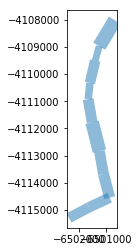

In [87]:
#ploteamos el resultado
nuevaH.plot(linewidth = nuevaH.distancia/80,alpha = 0.5)

## 7- Group by- Apply

Ya resolvimos el problema para la **línea H**. Ahora solamente tenemos que aplicar el mismo método y resolverlo para todas las líneas. Podríamos hacer un `for loop` iterando a lo largo de todas las líneas, y poner todo el proceso en un loop, e ir guardando los resultados. 

Pero para esta situación donde tenemos registros en una tabla identificados por un valor en común, y queremos realizar el mismo proceso para cada grupo, existe `Group By`. Ya lo utilizamos para obtener un promedio. Le aplicamos la función promedio a cada grupo. Ahora, podemos aplicarle una función algo más compleja a cada grupo.

Comencemos on un ejemplo sencillo. Vamos a crear una funcion que hace dos cosas: elimina algunas columnas y se queda con el primer registro

In [88]:
def funcion(dt):
    dt = dt.reindex(columns = ['ESTACION','LINEA','geometry'])
    dt = dt.iloc[0]
    return dt

In [89]:
#luego aplicamos esta funcion con un apply a todo el dataset
estaciones.groupby('LINEA').apply(funcion).reset_index(drop=True)

,ESTACION,LINEA,geometry
0,PERU,A,POINT (-6498127.365036696 -4110872.712542148)
1,FLORIDA,B,POINT (-6498216.843629339 -4110161.079893422)
2,RETIRO,C,POINT (-6498099.604554965 -4108524.30949048)
3,9 DE JULIO,D,POINT (-6498829.391967968 -4110289.281761676)
4,BOLIVAR,E,POINT (-6498062.411708559 -4110965.136153672)
5,CASEROS,H,POINT (-6500872.365264534 -4114550.922561814)


In [117]:
def distancia_entre_estaciones(dt,lineas):
    """
    Esta funcion produce un geoDataFrame con lineas entre estaciones
    de subte con la distancia en metros entre ellas
    ...
    
    Argumentos
    ---------
    dt     : geopandas.GeoDataFrame
            GeoDataFrame que contiene las estaciones de subte   
    lineas : geopandas.GeoDataFrame
            GeoDataFrame que contiene las lineas de subte
            
    Devuelve
    -------
    nuevo_dt: GeoDataFrame
            GeoDataFrame que contiene las lineas entre estaciones
            con la distancia entre ellas en metros
    """
    #Creo un diccionario con colores
    colores = {
        'A':'lightblue',
        'B':'red',
        'C':'blue',
        'D':'green',
        'E':'purple',
        'H':'gold'
    }
    #tomo la linea del subset de datos como el valor unico que hay en el campo LINEA
    linea_letra = dt.LINEA.unique()[0]
    #tomo el color para graficar en base a esa linea
    color = colores[linea_letra]
    
    #tomo la linea de subte en su geometria para el LRS
    linea = lineas.loc[linea_letra,'geometry']
    #limpio el subset de datos quedandome con pocas columnas
    dt = dt.reindex(columns = ['ESTACION','LINEA','geometry'])
    #proyecto cada estacion en la linea  lo guardo en orden
    dt['orden'] = dt.geometry.map(lambda estacion: linea.project(estacion,normalized = True))
    
    #ordeno por ese orden y reinicio el index
    dt = dt.sort_values(by='orden')
    dt = dt.reset_index(drop=True)
    
    #obtengo la estacion siguiente con un shift
    estacion_siguiente = dt.geometry.shift(-1)
    #calculo las distancias a la estacion siguiente
    distancias = [dt.geometry.loc[i].distance(estacion_siguiente.loc[i]) for i in dt.index[:-1]]
    
    #construyo una linea entre cada estacion y la siguiente
    lineas_nuevas = [LineString([dt.geometry.loc[i],estacion_siguiente.loc[i]]) for i in dt.index[:-1]]
    
    #creo el geodataframe final
    nuevo_dt = pd.DataFrame({'lineas':lineas_nuevas,
             'distancia':distancias})
    nuevo_dt = gpd.GeoDataFrame(nuevo_dt, geometry='lineas',crs={'init' :'epsg:3857'})
    #le doy el color
    nuevo_dt['color'] = color
    return nuevo_dt

In [118]:
lineas_subte = estaciones.groupby('LINEA').apply(lambda x: distancia_entre_estaciones(x,lineas))
#eliminino el nivel del index que no me intersa
lineas_subte.index = lineas_subte.index.droplevel(1)
lineas_subte.head()

,lineas,distancia,color
LINEA,,,
A,LINESTRING (-6508743.708323549 -4113868.689469...,713.416779,lightblue
A,LINESTRING (-6508064.783826949 -4113649.543334...,827.881000,lightblue
A,LINESTRING (-6507304.422239711 -4113322.072409...,992.752439,lightblue
A,LINESTRING (-6506406.984065079 -4112897.617314...,932.733759,lightblue
A,LINESTRING (-6505575.457346221 -4112475.058939...,601.756498,lightblue


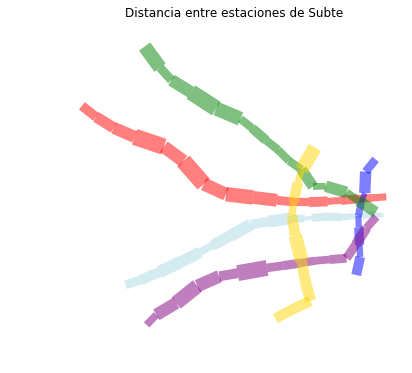

In [119]:
#veamoslo en un mapa
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

lineas_subte.plot(color = lineas_subte.color,
                  linewidth = lineas_subte.distancia/80,
                  alpha = 0.5,ax=ax)
ax.set_axis_off()
plt.axis('equal')
ax.set_title('Distancia entre estaciones de Subte')
fig.savefig('plot_distancia_lineas.png')

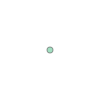

In [93]:
#En lugar de distancias podemos hacer un buffer, el caballo de batalla del análisis espacial más sencillo
#el buffer puede hacerse sobre un punto
from shapely.geometry import Point, LineString
punto = Point([1,1])
punto

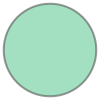

In [95]:
punto.buffer(0.5)

In [96]:
type(punto.buffer(0.5))

shapely.geometry.polygon.Polygon

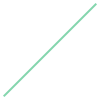

In [97]:
#sobre una linea
linea = LineString([punto,Point(2,2)])
linea

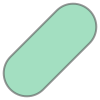

In [98]:
linea.buffer(0.5)

In [99]:
#y no siempre tiene que ser constante, podemos hacer distancias variables
#y aplicarlo de modo vectorial
lineas_subte['lineas'] = lineas_subte.apply(lambda x: x.lineas.buffer(x.distancia/10), axis=1)

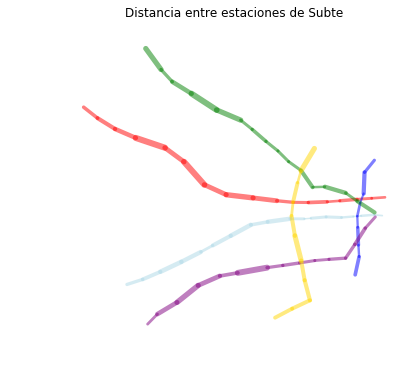

In [101]:
#veamoslo en un mapa
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

lineas_subte.plot(color = lineas_subte.color,
                  #linewidth = lineas_subte.distancia/80,
                  alpha = 0.5,ax=ax)
ax.set_axis_off()
plt.axis('equal')
ax.set_title('Distancia entre estaciones de Subte')
fig.savefig('plot_distancia_buffer.png')

## Crear un GeoDataFrame desde texto

In [102]:
#COMO CREAMOS UN GEODATAFRAME desde un csv?
from shapely import wkt
lineas2 = pd.read_csv('../carto/lineas-de-subte.csv')
lineas2.WKT = lineas2.WKT.apply(wkt.loads)
crs = {'init' :'epsg:4326'}
gdf = gpd.GeoDataFrame(lineas2, geometry='WKT',crs={'init' :'epsg:4326'})
gdf.head()


,WKT,id,lineasub
0,LINESTRING (-58.45212560312952 -34.56621524240...,1,LINEA D
1,LINESTRING (-58.45648913465165 -34.56230908800...,2,LINEA D
2,LINESTRING (-58.44466814742586 -34.57001230910...,3,LINEA D
3,LINESTRING (-58.43501353294445 -34.57517836531...,4,LINEA D
4,LINESTRING (-58.42571144108521 -34.57842202290...,5,LINEA D


In [103]:
#siempre conviene mantener la columnas de geometrias con el nombre geometry
gdf.columns = ['geometry','ID_LINEA','lineasub']
gdf.head()

,geometry,ID_LINEA,lineasub
0,LINESTRING (-58.45212560312952 -34.56621524240...,1,LINEA D
1,LINESTRING (-58.45648913465165 -34.56230908800...,2,LINEA D
2,LINESTRING (-58.44466814742586 -34.57001230910...,3,LINEA D
3,LINESTRING (-58.43501353294445 -34.57517836531...,4,LINEA D
4,LINESTRING (-58.42571144108521 -34.57842202290...,5,LINEA D


## 8 Como se comporta la demanda en las estaciones de subte según la hora y el tipo de día?

In [104]:
#vamos a crear una funcion para leer nuestros datos de acuerdo a si queremos un sabado o que hora
def leerData(tipo_de_dia,hora):
    db = pd.read_csv('../data/dataInsumo.csv')
    db = db.loc[db.hora == hora,:]
    if tipo_de_dia == 'fin de semana':
        return db.loc[db.fin_de_semana,['ID','promedio']]
    elif tipo_de_dia == 'dia de semana':
        return db.loc[~(db.fin_de_semana),['ID','promedio']]
    else:
        print('ERROR')

In [105]:
#corremos la funcion para testear que funcione
dt = leerData(tipo_de_dia = 'dia de semana', hora = 8)
dt.head()

,ID,promedio
172,31,2.789474
173,32,3.586957
174,33,4.985816
175,34,5.587302
176,35,7.417722


In [106]:
#convertirmos la columna ID en texto
estaciones.ID = estaciones.ID.map(int)
estaciones.head()

,ID,ESTACION,LINEA,geometry,x,y,distancia
0,1,CASEROS,H,POINT (-6500872.365264534 -4114550.922561814),-58.398330,-34.636196,4675.974617
1,2,INCLAN,H,POINT (-6501099.673119548 -4113688.521703297),-58.400372,-34.629822,4007.894552
2,3,HUMBERTO 1°,H,POINT (-6501250.307275812 -4112838.521641664),-58.401725,-34.623539,3401.928261
3,4,VENEZUELA,H,POINT (-6501518.470772369 -4111776.653996726),-58.404134,-34.615689,2906.283270
4,5,ONCE - 30 DE DICIEMBRE,H,POINT (-6501663.705051661 -4110923.61029132),-58.405439,-34.609382,2701.909100


In [107]:
#hacemos un merge, manteniendo toda la informacion de las esatciones "left join"
estaciones = estaciones.merge(dt,on='ID',how='left')
estaciones.head()

,ID,ESTACION,LINEA,geometry,x,y,distancia,promedio
0,1,CASEROS,H,POINT (-6500872.365264534 -4114550.922561814),-58.398330,-34.636196,4675.974617,8.053097
1,2,INCLAN,H,POINT (-6501099.673119548 -4113688.521703297),-58.400372,-34.629822,4007.894552,13.174603
2,3,HUMBERTO 1°,H,POINT (-6501250.307275812 -4112838.521641664),-58.401725,-34.623539,3401.928261,12.447761
3,4,VENEZUELA,H,POINT (-6501518.470772369 -4111776.653996726),-58.404134,-34.615689,2906.283270,11.669811
4,5,ONCE - 30 DE DICIEMBRE,H,POINT (-6501663.705051661 -4110923.61029132),-58.405439,-34.609382,2701.909100,8.196347


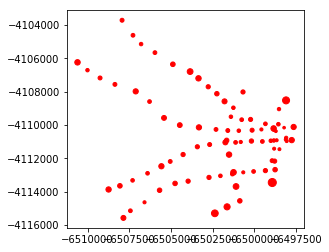

In [108]:
estaciones.plot(marker='.', color='red', markersize = estaciones['promedio']*10)

In [109]:
#hacemos una funcion para que haga todo lo que hicimos recien, de modo automatico

def verSubte(tipo_de_dia,hora):
    #esta es la misma funcion que hicimos
    dt = leerData(tipo_de_dia, hora)
    #leemos las estaciones
    estaciones = gpd.read_file('../carto/estaciones_de_subte.shp')
    #modificamos el ID como numero
    estaciones.ID = estaciones.ID.map(int)
    #realizamos el merge
    estaciones = estaciones.merge(dt,on='ID',how='left')
    #realizamos el plot
    estaciones.plot(marker='.', color='red', markersize = estaciones['promedio']*10)

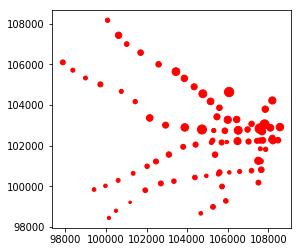

In [110]:
verSubte(hora = 21,tipo_de_dia = 'fin de semana')

In [115]:
def verSubteLindo(hora,tipo_de_dia,linea):
    import seaborn as sns
    #leo los datos de los molinetes
    dt = leerData(tipo_de_dia, hora)
    #lo la cartografia de las estaciones
    estaciones = gpd.read_file('../carto/estaciones_de_subte.shp')
    #estaciones = estaciones.to_crs(epsg=4326)
    #uno la cartografia con los datos
    estaciones.ID = estaciones.ID.map(int)
    estaciones = estaciones.merge(dt,on='ID',how='left')
    #leo una cartografia de fondo
    comunas = gpd.read_file('../carto/comunas.shp')
    #comunas = comunas.to_crs(epsg=4326)
    
    lineas = gpd.read_file('../carto/lineas_de_subte.shp')
    lineas = lineas.loc[lineas.Linea == linea,:]
    lineas = lineas.to_crs(estaciones.crs)

    estaciones['orden'] = estaciones.geometry.map(lambda estacion: lineas.project(estacion,normalized = True).iloc[0])
    
    #genero los ejes
    fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    #la paleta de color
    colores = {
        'A':'lightblue',
        'B':'red',
        'C':'blue',
        'D':'green',
        'E':'purple',
        'H':'gold'
    }
    
    #ordeno las estaciones
    subdata = estaciones.loc[estaciones.LINEA==linea,:].sort_values(by='orden')
    
    #ploteo el mapa base
    comunas.plot(ax=ax1,alpha=0.5,color='grey')
    #ploteo estaciones de la linea seleccionada y las otras
    estaciones.plot(ax = ax1, marker='.', color='black', markersize = estaciones['promedio']*10,alpha=0.4)
    subdata.plot(ax = ax1, marker='.', color=colores[linea], markersize = subdata['promedio']*10,alpha=0.8)
    
    #elimino los ejes
    ax1.set_axis_off()
    
    #creo el bar plot
    sns.barplot(x="ESTACION", y="promedio", data=subdata,ax=ax2,color=colores[linea])
    
    #agrego etiquetas para eje x
    for tick in ax2.get_xticklabels():
        tick.set_rotation(70)
    
    #equiparo la proporcion
    ax1.axis('equal')

    fig.suptitle('Linea ' + linea + '- '+ str(hora) + ' hs ' + tipo_de_dia, fontsize=16)



C:\Users\FGONZALEZ\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


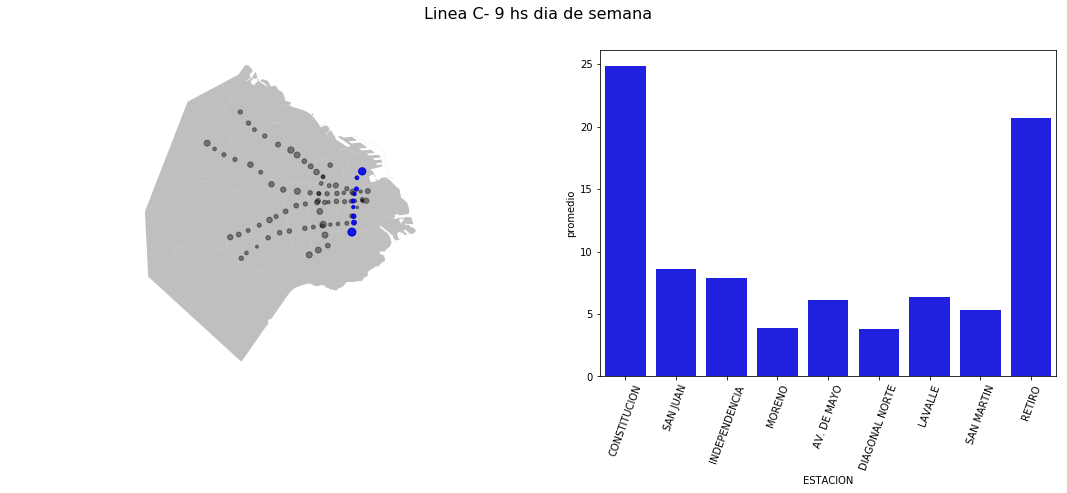

In [116]:
verSubteLindo(hora = 9,tipo_de_dia = 'dia de semana',linea = 'C')

# Tarea para el hogar

Pueden realizar dos tareas como práctica:

* Ubiquen el centro de coordenadas de Gaus - Krugger para Buenos Aires que vimos en la proyeccion usada por GCBA. Calculen la distancia a ese punto de sitios de interes (Obelisco, el Km O en el congreso, La Casa Rosada)

* Construyan un gráfico de dispersión, o scatter plot, donde evalúen si la distancia al obelisco de las estaciones se correlaciona (al menos en una inspección visual) con su distancia al obelisco. Pueden hacerlo para una linea o para todas.